In [3]:
import pandas as pd
import numpy as np
import pickle
import datetime
from src.modeling import *
from src.feature_engineering import *
from src.portfolio import *
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from hyperopt import hp
import shap
shap.initjs()

In [2]:
loans = pd.read_pickle('data/df_EDA.pkl.bz2', compression='bz2')

with open('data/loan_rois.pickle', 'rb') as handle:
    loan_rois = pickle.load(handle)
    
loans['roi'] = pd.Series(loan_rois)
issue_dates = dict(zip(loans.index, loans['issue_d']))

In [15]:
payments = pd.read_pickle('data/df_payments_testing_loans.pkl.bz2', compression='bz2')
payments.tail()

RECEIVED_AMT_INVESTORS  PBAL_END_PERIOD_INVESTORS  \
RECEIVED_D LOAN_ID                                                        
2020-08-01 169182703              650.169983                3418.959961   
           169185346              669.049988                 851.140015   
           169188486              218.490005                3315.239990   
           169195300              227.520004                5311.250000   
           169225459             1394.140015                1560.839966   

                     IssuedDate  mths_since_issue  
RECEIVED_D LOAN_ID                                 
2020-08-01 169182703 2020-06-01                 2  
           169185346 2020-06-01                 2  
           169188486 2020-06-01                 2  
           169195300 2020-06-01                 2  
           169225459 2020-06-01                 2

In [8]:
X_test  = pd.read_pickle('data/X_test.pkl.bz2',  compression='bz2')
X_train = pd.read_pickle('data/X_train.pkl.bz2', compression='bz2')
y_train = pd.read_pickle('data/y_train.pkl.bz2', compression='bz2')

In [5]:
df_testing = X_test.copy(deep=True)
df_testing['issue_d'] = pd.Series(issue_dates)

In [67]:
cash_balance = []
rois = []

model = XGBRegressor(objective='reg:squarederror', tree_method='gpu_hist', learning_rate=.1)
fit_model = train_model(model, X_train, y_train)
predicted_rois = get_predictions(fit_model, X_test)
simulation_df = create_dataframe_for_simulation(df_testing, predicted_rois)
predictions_xgb = simulation_df
dates, balances_xgb, roi_xgb = simulate_loan_investment_portfolio(payments, predictions_xgb, start_date,
                                                                    end_date, starting_balance, investment_per_loan, min_roi)
cash_balance.append(balances_xgb[-1])
rois.append(roi_xgb)

In [68]:
predictions_xgb = simulation_df
dates, balances_xgb, roi_xgb = simulate_loan_investment_portfolio(payments, predictions_xgb, start_date,
                                                                    end_date, starting_balance, investment_per_loan, min_roi)

\$74677 ending balance for the initial XGBoost model

In [36]:
balances_xgb[-1]

74677.97309708718

In [ ]:
model = GradientBoostingRegressor(subsample=.5, n_estimators=2000, random_state=91)
fit_model = train_model(model, X_train, y_train)
predicted_rois = get_predictions(fit_model, X_test)
simulation_df = create_dataframe_for_simulation(df_testing, predicted_rois)
simulation_df.head()

In [ ]:
start_date = datetime.date(2017,8,1)
end_date = datetime.date(2020,7,1)
starting_balance = 50000
investment_per_loan = 100
min_roi = 10.0

In [ ]:
predictions_gbrt = simulation_df
dates, balances_gbrt, roi_gbrt = simulate_loan_investment_portfolio(payments, predictions_gbrt, start_date,
                                                                    end_date, starting_balance, investment_per_loan, min_roi)

In [ ]:
balances_gbrt

# XGBoost Custom Loss

In [11]:
def loss(yhat, y, λ=2):
    return (y - yhat)**2 + λ * (y - yhat)**2 * (yhat > y)
def dloss(yhat, y, λ=2):
    return -2 * (y - yhat) - 2 * λ * (y - yhat) * (yhat > y)
def ddloss(yhat, y, λ=2):
    return 2 + 2 * λ * (yhat > y)

In [10]:
λ = 2

In [29]:
def custom_loss(y_true, y_pred):
    grad = dloss(y_pred, y_true, 3)
    hess = ddloss(y_pred, y_true, 3)
    return grad, hess

In [25]:
def gradient(predt: np.ndarray, dtrain: xgb.DMatrix) -> np.ndarray:
    '''Compute the gradient squared log error.'''
    λ = 2
    y = dtrain.get_label()
    yhat = predt
    return -2 * (y - yhat) - 2 * λ * (y - yhat) * (yhat > y)

def hessian(predt: np.ndarray, dtrain: xgb.DMatrix) -> np.ndarray:
    '''Compute the hessian for squared log error.'''
    λ = 2
    y = dtrain.get_label()
    yhat = predt
    return 2 + 2 * λ * (yhat > y)

def custom_loss(predt: np.ndarray, dtrain: xgb.DMatrix):
    grad = gradient(predt, dtrain)
    hess = hessian(predt, dtrain)
    return grad, hess

In [26]:
y_train

id
477567       12.995635
477585       16.152673
474990       11.672195
477531       14.784254
477639       13.321605
               ...    
112879753    20.093997
113061509     7.617606
113047179    16.132794
112537336    14.494238
111896701    18.016953
Name: roi, Length: 1097123, dtype: float64

In [33]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

In [38]:
dtrain.get_label()

array([12.995635, 16.152674, 11.672195, ..., 16.132793, 14.494239,
       18.016953], dtype=float32)

In [31]:
fit_model = xgb.train({'tree_method': 'gpu_hist', 'seed': 91}, dtrain=dtrain, obj=custom_loss)

In [34]:
fit_model.predict(dtest)

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5], dtype=float32)

In [6]:
fit_model.predict(X_train)

array([4.4072123, 2.208839 , 8.682607 , ..., 4.606778 , 2.9541023,
       5.071996 ], dtype=float32)

In [7]:
explainer = shap.TreeExplainer(fit_model)
shap_values = explainer.shap_values(X_train)

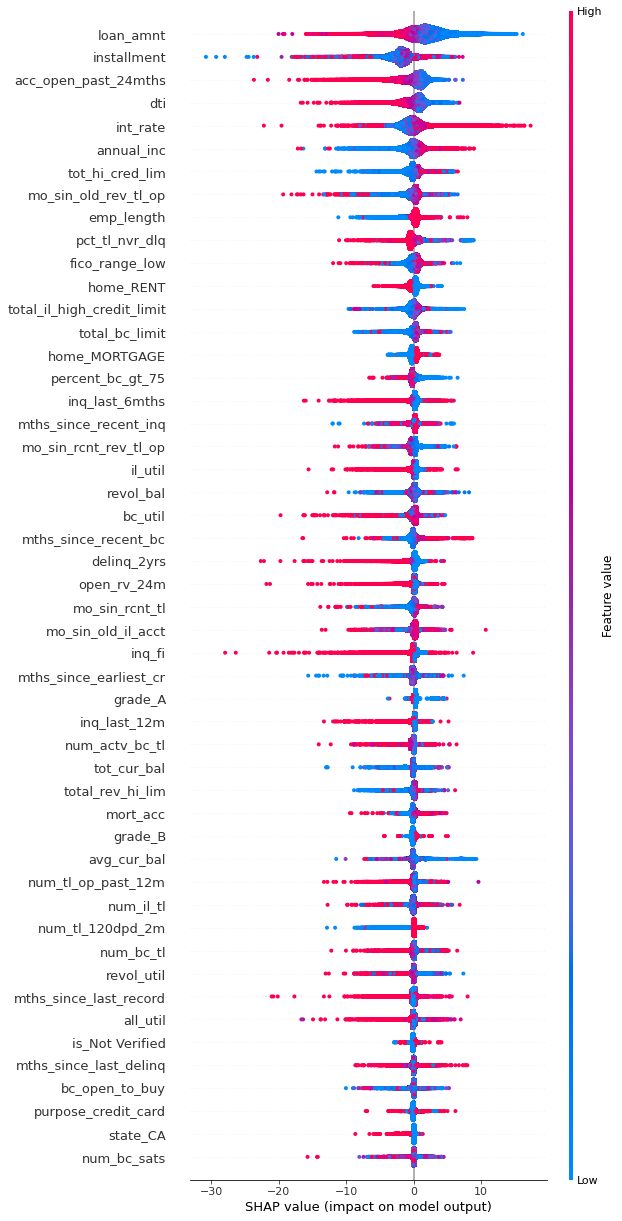

In [14]:
shap.summary_plot(shap_values, X_train, max_display=50)

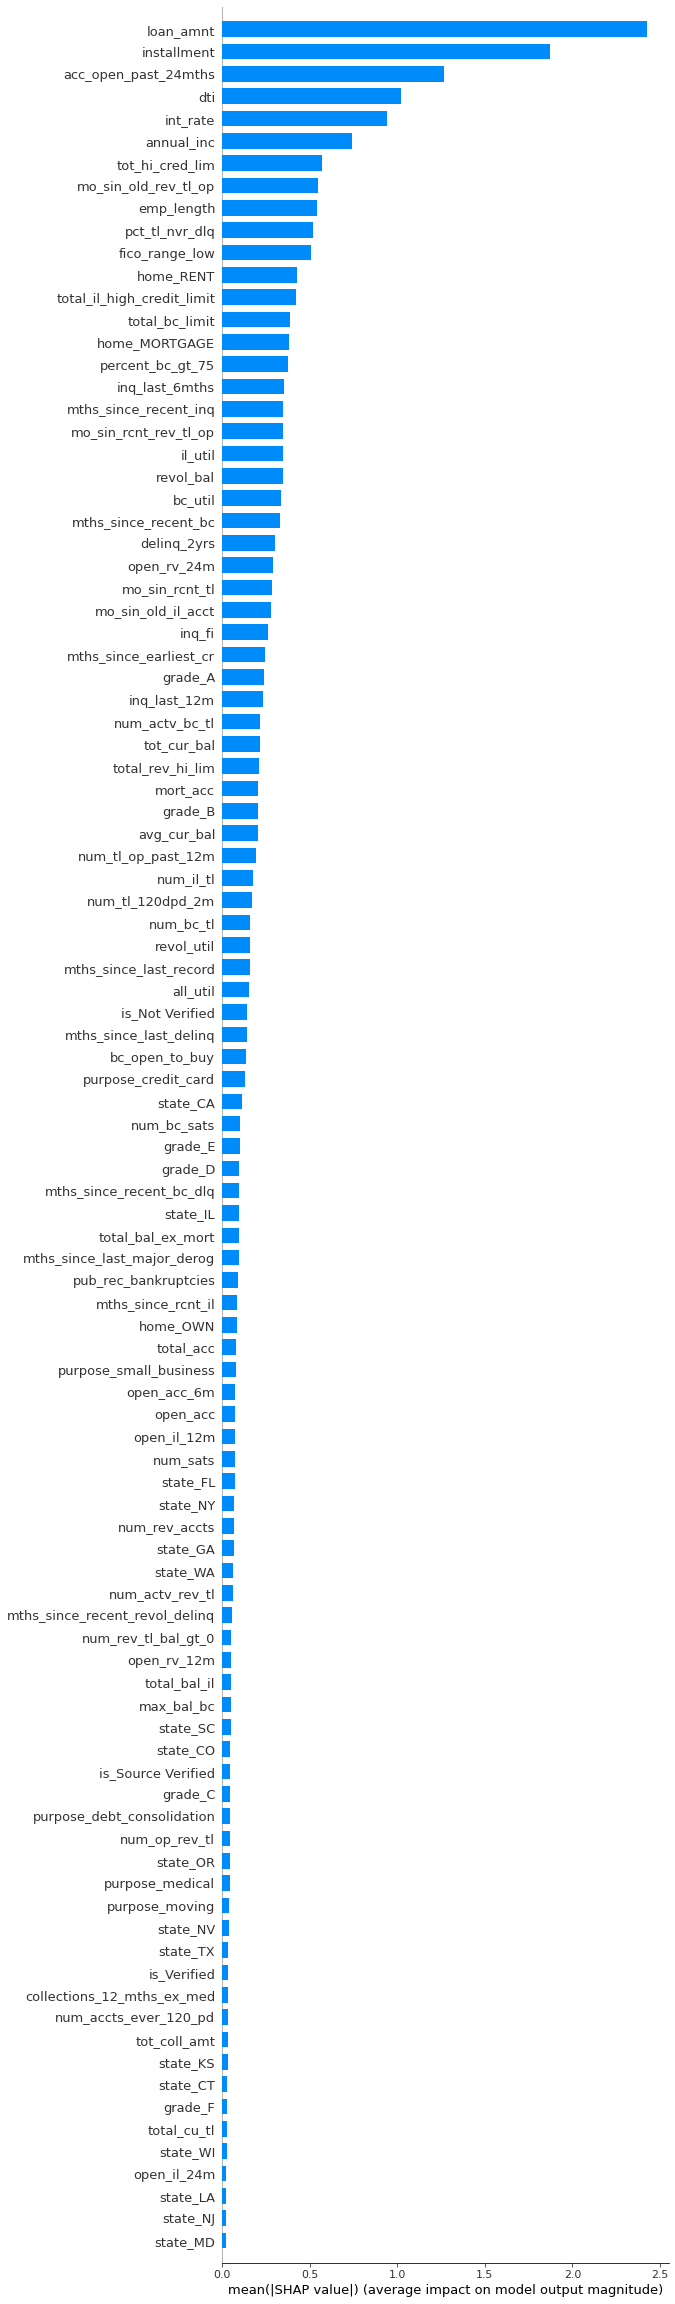

In [12]:
shap.summary_plot(shap_values, X_train, plot_type='bar', max_display=100)

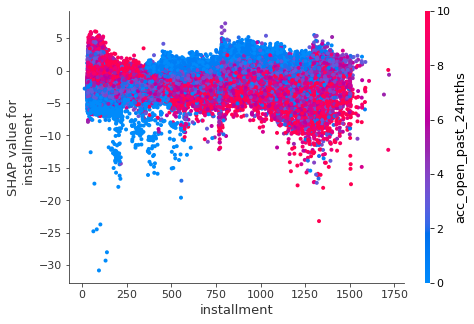

In [16]:
shap.dependence_plot('installment', shap_values, X_train)

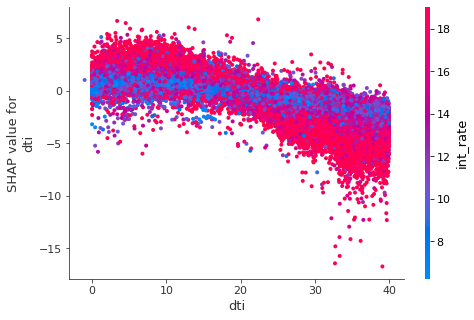

In [18]:
shap.dependence_plot('dti', shap_values, X_train)

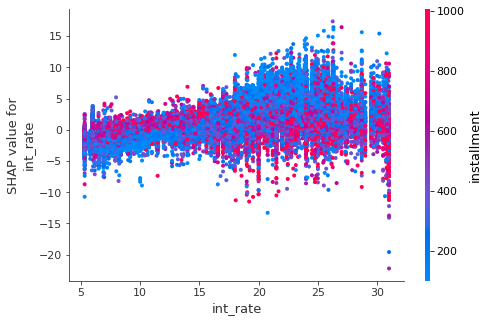

In [19]:
shap.dependence_plot('int_rate', shap_values, X_train)